File created by Jinghao Chen (jinghc2@uci.edu).

Make sure file "gfp.pkl" is in the directory.

In [1]:
import pickle

In [2]:
pickle_in = open("gfp.pkl","rb")
gfp = pickle.load(pickle_in)

Check the first 5 reads from the bin #0.

In [3]:
gfp[0][:5]

['AATTAATGTGAGTTAGCTCACTCATTAGGCCCCCCAGGGTTTACACTTTTTGCTACCGTCTCGTATGTTGTTTGC',
 'AATTAAGTAGAGATCGCTCACTCATTAGGCACCCAAGCCGTTACATTTTATGCTTCAGGCCCGTACGCTGTGTGT',
 'GCTTAATGGGAGTGAGCTCACTCATTAGGCACCCCAGTCTTTAGACTTTATGCTTCCGGCTCGTATCTTGCGTGG',
 'GCCCACTCTGAGTTAGCTCAACCACTATGCACCCCAGGCTCTACGCTATTTGATTCCGGCCTGATTGTTGTGTGA',
 'AATTAATGTGAGTTAGCTCACTCATTTGGCAACCCAGTCTTTACCCTTTATGCTTCCGACTCGTATGTTGTTTGG']

The effective area is [-75,-1] so the length should be 75.

In [4]:
len(gfp[0][0])

75

Define 2 functions for future use.

In [5]:
def bp2bi(sq):
    '''base pairs to binary data'''
    l = []
    for bp in sq:
        if bp == 'A':
            l += [1,0,0,0]
        elif bp == 'C':
            l += [0,1,0,0]
        elif bp == 'G':
            l += [0,0,1,0]
        elif bp == 'T':
            l += [0,0,0,1]
        else:
            print('Error: please ensure only ACGT nucliotides contained.')
            return
    return l

In [6]:
def gfp2data(gfp,bin_min,bin_max,pt_min,pt_max):
    '''gfp to data in the standard form: feature values + label value'''
    data = []
    for k in range(bin_min,bin_max+1):
        for sq in gfp[k]:
            l = bp2bi(sq[pt_min:pt_max+1]) if pt_max != -1 else bp2bi(sq[pt_min:])
            l.append(k)
            data.append(l)
    return data

Import numpy package.

In [7]:
import numpy as np
np.random.seed(114514)

Generate standard-form data, basically feature values + label (target) value.

In [8]:
data = gfp2data(gfp,1,9,-74,-49) # CRP binding sites: [-74:-49]
data = np.array(data,np.float32)

Check the data we obtain.

In [9]:
M, N = data.shape

In [10]:
M, N

(46054, 105)

Import packages for machine learning model:

In [11]:
from __future__ import division
import torch
torch.manual_seed(1919810)
import sys
sys.path.append('code')
import mltools as ml # make sure this is installed or already in the directory
import matplotlib.pyplot as plt   # use matplotlib for plotting with inline plots

In [12]:
X, Y = data[:,:-1], data[:,-1]   # get features & target
X, Y = ml.shuffleData(X,Y)       # reorder randomly rather than by class label

Usually we can rescale to improve numerical stability, speed convergence. But in this context, we have to keep minimal model in order to reserve its physical meaning, i.e., explanable from the first principle.

In [13]:
# X,_  = ml.transforms.rescale(X)

We only use batches 1-4 and 6-9 (without 5) for our initial test, and make binary labels.

In [14]:
XA, YA = X[Y!=5,:], Y[Y!=5]
YA = np.heaviside(YA-5,-1)

In [15]:
class logisticClassify(ml.classifier):     # trivial shell class to contain whatever we want
    def predict(self,X): pass               # we will replace the shell later as we extend the class
    def train(self,X): pass

In [16]:
def myPredict(self,X):
    '''Predict model on data X; return nparray of class predictions'''
    R = torch.Tensor(X) @ self.theta[1:] + self.theta[0]  # compute linear response
    Y01 = 1*(R>0)                   # binary classification threshold; convert to integers
    Y = self.classes[Y01]           # use lookup to convert back to class values if given
    return Y                        # NOTE: returns as numpy, not torch! (b/c classes is a nparray)
                                    # (This is necessary for mltools plot to work)

In [17]:
# Create a shell classifier
class logisticClassify(ml.classifier):
    predict = myPredict              #
    train = None                     # this function will be implemented later

In [18]:
from IPython import display

def myTrain(self,X,Y, initStep=1.,stopTol=1e-4,stopEpochs=5000,alpha=0,plot=None):
    """ Train the logistic regression using stochastic gradient descent """
    M,N = X.shape;                     # initialize the model if necessary:
    self.classes = np.unique(Y);       # Y may have two classes, any values
    X1 = np.hstack((np.ones((M,1)),X)) # X1 is X, but with an extra column of ones
    Y01 = ml.toIndex(Y,self.classes);  # Y01 is Y, but with canonical values 0 or 1
    
    # if the shape of initial theta is wrong, randomly generate a correct one
    if len(self.theta)!=N+1: self.theta=torch.randn((N+1,1),requires_grad = True);
        
    # init loop variables:
    epoch=0; done=False; Jnll=[]; J01=[];            # initialize loop variables
    myrate = lambda epoch: initStep*2.0/(2.0+epoch)  # step size as a f'n of epoch

    opt = torch.optim.SGD([self.theta], initStep)
    sched = torch.optim.lr_scheduler.LambdaLR(opt, myrate)
    
    while not done:
        # Do an SGD pass through the entire data set:
        Jnll.append(0.)
        for i in np.random.permutation(M):
            # Compute predictions and loss for *just* data X[i]:
            ri = torch.tensor(X1[i],dtype=torch.float32) @ self.theta;
            si = 1/(1+torch.exp(-ri)); # logistic (probability) prediction of the class
            Ji = -Y01[i]*torch.log(si)-(1-Y01[i])*torch.log(1-si); # torch.Tensor shape [] (scalar)
            Jnll[-1] += float(Ji)/M             # find running average of surrogate loss
            opt.zero_grad()                     # Ji should be a torch.tensor of shape []
            Ji.backward()
            opt.step()
        sched.step()        

        epoch += 1
        J01.append( self.err(X,Y) )  # evaluate the current actual error rate 

        display.clear_output(wait=True); plt.figure(figsize=(15,5));
        plt.subplot(1,2,1); 
        plt.cla(); plt.plot(Jnll,'b-'); plt.xlabel('epoch'); plt.ylabel('surrogate loss');    # plot losses
        plt.subplot(1,2,2); 
        plt.cla(); plt.plot(J01,'r-'); plt.xlabel('epoch'); plt.ylabel('error rate');    # plot error rate
        plt.show(); plt.pause(.001);                    # let OS draw the plot

        ## For debugging: you may want to print current parameters & losses
        # print(self.theta, ' => ', Jnll, ' / ', J01[-1] )
        # input()   # pause for keystroke

        # check stopping criteria: exit if exceeded # of epochs ( > stopEpochs)
        done = epoch > stopEpochs or abs(Jnll[-1]) < stopTol;   # or if Jnll not changing between epochs ( < stopTol )


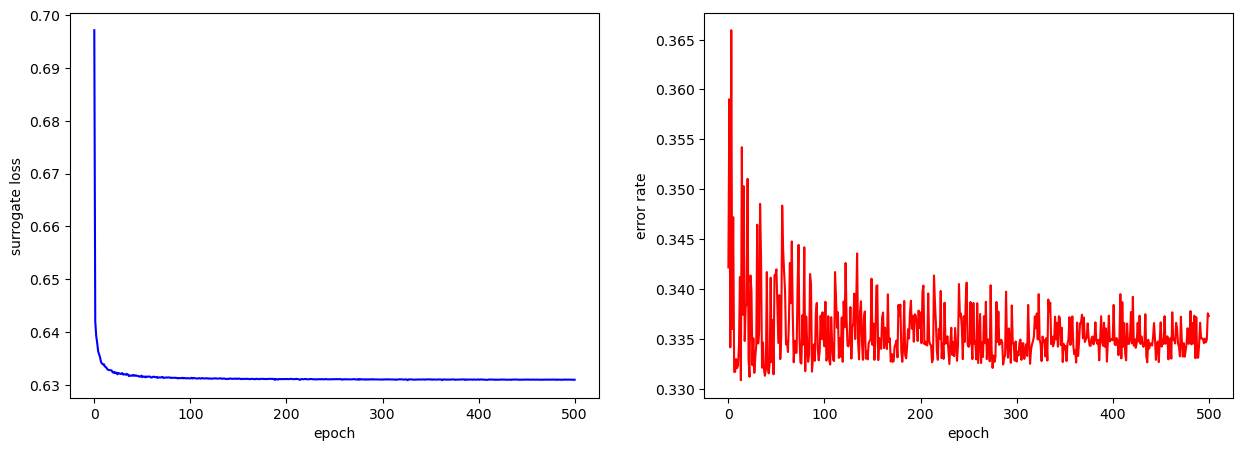

In [19]:
# Update our shell classifier definition
class logisticClassify(ml.classifier):
    predict = myPredict              # Now all parts are implemented
    train = myTrain

learnerA = logisticClassify()
learnerA.classes = np.unique(YA)
learnerA.theta = 0.5+0.2*torch.randn((N+1,1),requires_grad = True) # or deterministic: torch.tensor([.5]*N,requires_grad = True)
learnerA.train(XA,YA,initStep=1e-1,stopEpochs=500,stopTol=1e-5);

Change back into numpy format for visualization and analysis, and save it if necessary.

In [20]:
theta_np = learnerA.theta.detach().numpy()

# pickle_out = open("type_your_variable_name_here.pkl","wb")
# pickle.dump(theta_np, pickle_out)
# pickle_out.close()

Reshape it into the form of energy matrix, adjust sign. The sign was reversed because we correlate the higher energy value to the higher fluorescence level, while the highest fluorescence level should actually be from wild-type, which has the lowest binding energy, hence the relation should be reversed back.

In [21]:
n = int((N-1)/4)

In [22]:
theta = - np.transpose(np.reshape(theta_np[1:],(n,4)))

Energy shift.

In [23]:
for i in range(n):
    theta[:,i] -= min(theta[:,i])

For arbitrary unit (non-dimensional).

In [24]:
theta = theta/theta.max()

Plot the energy matrix:

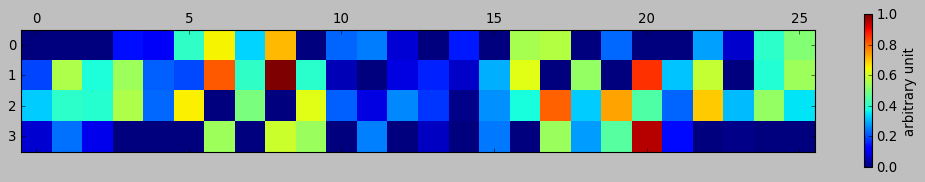

In [27]:
plt.matshow(theta)
plt.colorbar(label='arbitrary unit')
plt.style.use('classic')
plt.show()

Now we turn to RNAP.

In [28]:
data1 = gfp2data(gfp,1,9,-41,-1) # RNAP binding sites: [-41:-1]
data1 = np.array(data1,np.float32)

Check the data shape.

In [29]:
M1, N1 = data1.shape

In [30]:
M1, N1

(46054, 165)

Now we literally just need to repeat everything analogously.

In [31]:
X1, Y1 = data1[:,:-1], data1[:,-1]   # get features & target
X1, Y1 = ml.shuffleData(X1,Y1)       # reorder randomly rather than by class label

In [32]:
XB, YB = X1[Y1!=5,:], Y1[Y1!=5]
YB = np.heaviside(YB-5,-1)

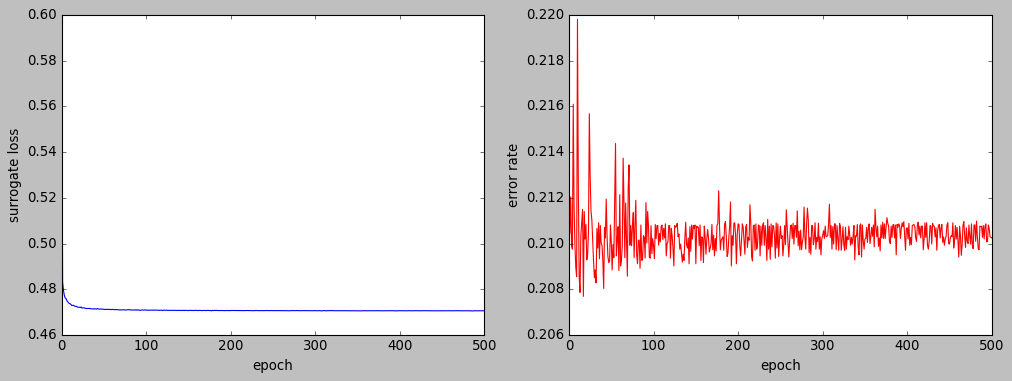

In [33]:
learnerB = logisticClassify()
learnerB.classes = np.unique(YB)
learnerB.theta = 0.5+0.2*torch.randn((N1+1,1),requires_grad = True) # or deterministic: torch.tensor([.5]*N1,requires_grad = True);
learnerB.train(XB,YB,initStep=1e-1,stopEpochs=500,stopTol=1e-5);

In [34]:
theta1_np = learnerB.theta.detach().numpy()

# pickle_out = open("type_your_variable_name_here.pkl","wb")
# pickle.dump(theta1_np, pickle_out)
# pickle_out.close()

In [35]:
theta1_np.shape

(165, 1)

In [36]:
n1 = int((N1-1)/4)

In [37]:
theta1 = - np.transpose(np.reshape(theta1_np[1:],(n1,4)))

In [38]:
for i in range(n1):
    theta1[:,i] -= min(theta1[:,i])

In [39]:
theta1 = theta1/theta1.max()

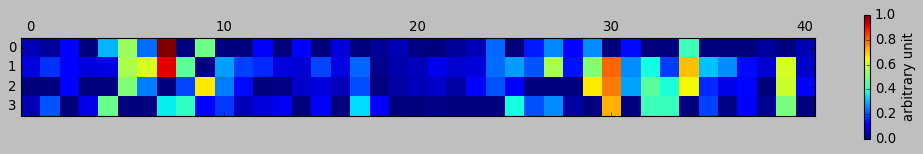

In [40]:
plt.matshow(theta1)
plt.colorbar(label='arbitrary unit')
plt.style.use('classic')
plt.show()